# Adversarial Robustness Toolbox for Provenance-Based Defenses

In this notebook we will learn how to use ART to defend against adversarial attacks in IoT settings.

When data is collected from multiple sources, we can use **provenance features** to track the origin of that data. Using those features, we can defend models against malicious attacks. We will also show how to use the Reject on Negative Impact (RONI) defense method within ART.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from art.attacks.poisoning.poisoning_attack_svm import PoisoningAttackSVM
from art.estimators.classification.scikitlearn import ScikitlearnSVC
from art.defences.detector.poison import ProvenanceDefense, RONIDefense
from art.utils import load_mnist
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(301)

import warnings
warnings.filterwarnings('ignore')

## Set Hyperparameters

In [2]:
num_training = 40
num_poison = 5
num_valid = 40 # the number of valid examples for the attacker
num_trusted = 25 # the number of trusted data for the defender
num_devices = 4 # last device is inserting poison
kernel = 'linear' # available kernels are 'rbf', 'poly' and 'linear'

## Load and transform MNIST data

In this examples we are training a classifer that differentiates between the number 4 and the number 0. The training data is split between the first `num_devices - 1` devices and the poisoned training data is the added to the last device. Quantity fo data and model kernel are specified by hyperparameters

In [3]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_mnist()
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)
zero_or_four = np.logical_or(y_train == 4, y_train == 0)
x_train = x_train[zero_or_four]
y_train = y_train[zero_or_four]
tr_labels = np.zeros((y_train.shape[0], 2))
tr_labels[y_train == 0] = np.array([1, 0])
tr_labels[y_train == 4] = np.array([0, 1])
y_train = tr_labels


zero_or_four = np.logical_or(y_test == 4, y_test == 0)
x_test = x_test[zero_or_four]
y_test = y_test[zero_or_four]
te_labels = np.zeros((y_test.shape[0], 2))
te_labels[y_test == 0] = np.array([1, 0])
te_labels[y_test == 4] = np.array([0, 1])
y_test = te_labels

n_samples_train = x_train.shape[0]
n_features_train = x_train.shape[1] * x_train.shape[2] * x_train.shape[3]
n_samples_test = x_test.shape[0]
n_features_test = x_test.shape[1] * x_test.shape[2] * x_test.shape[3]

x_train = x_train.reshape(n_samples_train, n_features_train)
x_test = x_test.reshape(n_samples_test, n_features_test)
x_train = x_train[:num_training]
y_train = y_train[:num_training]

trusted_data = x_test[:num_trusted]
trusted_labels = y_test[:num_trusted]
x_test = x_test[num_trusted:]
y_test = y_test[num_trusted:]
valid_data = x_test[:num_valid]
valid_labels = y_test[:num_valid]
x_test = x_test[num_valid:]
y_test = y_test[num_valid:]

### Add provenance data and poison samples

*Note:* In real application scenarios, provenance data is also loaded. Provenance data is generated for this experiment for demonstration purposes.

This code will take longer to run depending on the number of poison samples you allow. Each samples is being generated independently, iteratively maximizing the generalization loss of the original SVM

In [5]:
# assign random provenance features to the original training points
clean_prov = np.random.randint(num_devices - 1, size=x_train.shape[0])
p_train = np.eye(num_devices)[clean_prov]

no_defense = ScikitlearnSVC(model=SVC(kernel=kernel), clip_values=(min_, max_))
no_defense.fit(x=x_train, y=y_train)
# poison a predetermined number of points starting at training points
poison_points = np.random.randint(no_defense._model.support_vectors_.shape[0], size=num_poison)
all_poison_init = np.copy(no_defense._model.support_vectors_[poison_points])
poison_labels = np.array([1,1]) - no_defense.predict(all_poison_init)


svm_attack = PoisoningAttackSVM(classifier=no_defense, x_train=x_train, y_train=y_train,
                                step=0.1, eps=1.0, x_val=valid_data, y_val=valid_labels)

poisoned_data, _ = svm_attack.poison(all_poison_init, y=poison_labels)

# Stack on poison to data and add provenance of bad actor
all_data = np.vstack([x_train, poisoned_data])
all_labels = np.vstack([y_train, poison_labels])
poison_prov = np.zeros((num_poison, num_devices))
poison_prov[:,num_devices - 1] = 1
all_p = np.vstack([p_train, poison_prov])

SVM poisoning: 0it [00:00, ?it/s]

### Visualize Poison

By changing the value of `idx` from 0 to `num_poison - 1` you can visualize each poison sample. Notice how they attempt to add features from the other class to confuse the classifier.

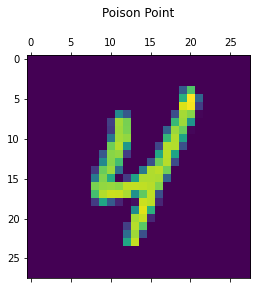

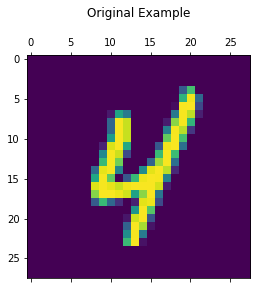

In [6]:
idx = 0
plt.matshow(poisoned_data[idx].reshape(28, 28))
plt.title("Poison Point\n")
plt.matshow(all_poison_init[idx].reshape(28, 28))
plt.title("Original Example\n")
plt.clim(0,1)

Notice that sometimes the poison appears to be a number 4 with features of the number zero in the background. It may appear as a shadowed zero "watermarking" the four. The aim of inserting poisonous samples like these in the training set is to shift the decision boundary so actual 0s to also become classified as 4s. 

In [7]:
# Train clean classifier and poisoned classifier
perfect_defense = ScikitlearnSVC(model=SVC(kernel=kernel), clip_values=(min_, max_))
perfect_defense.fit(x=x_train, y=y_train)
no_defense.fit(x=all_data, y=all_labels)

In [8]:
perf_acc = np.average(np.all(perfect_defense.predict(x_test) == y_test, axis=1)) * 100
no_acc = np.average(np.all(no_defense.predict(x_test) == y_test, axis=1)) * 100
print("Perfect defense accuracy (trusted set) {0:.2f}%".format(perf_acc))
print("No defense accuracy (trusted set) {0:.2f}%".format(no_acc))

Perfect defense accuracy (trusted set) 97.68%
No defense accuracy (trusted set) 80.23%


## Apply Defenses

We will apply the following defenses to this poisoning attack:
* **Perfect Defense** — All poison is detected and model is trained on clean data.
* **Provenance-Based Defense with Trusted Data** — Poison is detected using the provenance defense algorithm specified above.
* **Provenance-Baseed Defense without Trusted Data** — Assuming no validation data, just check each data segment for suspected poison.
* **RONI Defense w/ Calibration** — Poison is detecting using RONI defense method (see below).
* **RONI Defense w/o Calibration** — Suspicious poison is found by a threshold epsilon value
* **No defense** — Model is trained with poisoned data

### RONI Defense


In [9]:
from IPython.display import HTML
HTML('<img src="../utils/data/images/roni.gif">')

The [RONI (Reject on Negative Impact) defense method](https://www.usenix.org/legacy/event/leet08/tech/full_papers/nelson/nelson_html/#SECTION00051000000000000000) checks the empirical effect of each point on the performance of the classifier and removes suspicious points. Our is similar except instead of checking each point we check each set of points with the same provenance feature. We evaluate the defense with both the provenance defense and the perfect defense

In [10]:
%%capture
roni_defense = RONIDefense(no_defense, all_data, all_labels, trusted_data, trusted_labels)
roni_defense.detect_poison()
roni_no_cal = RONIDefense(no_defense, all_data, all_labels, trusted_data, trusted_labels)
roni_no_cal.detect_poison()

### Provenance Defense

In [11]:
from IPython.display import HTML
HTML('<img src="../utils/data/images/prov_defense.gif">')

The provenenace defense method checks the effect of removing segments of the data that may come a bad actor intentionally poisoning the data. When a sector is found that is potentially poisonous, it is flagged as suspicious.

In the trusted data version of the algorithm, the defender has some handpicked trusted data to test the performance of the model. In the version of the algorithm without trusted data, a random subset of training points from all segments are used as the test set.

In [12]:
%%capture
prov_defense_trust = ProvenanceDefense(no_defense, all_data, all_labels, all_p, 
                                       x_val=trusted_data, y_val=trusted_labels, eps=0.1)
prov_defense_trust.detect_poison()
prov_defense_no_trust = ProvenanceDefense(no_defense, all_data, all_labels, all_p, eps=0.1)
prov_defense_no_trust.detect_poison()

## Evaluate Defenses

In [13]:
real_is_clean = np.array([1 if i < num_training else 0 for i in range(len(all_data))])
def evaluate_defense(defense, name):
    print("\nEvaluating results of {} defense...".format(name))
    pc_tp = np.average(real_is_clean[:num_training] == defense.is_clean_lst[:num_training]) * 100
    pc_tn = np.average(real_is_clean[num_training:] == defense.is_clean_lst[num_training:]) * 100
    print("Percent of normal points correctly labeled (True Negative): {0:.2f}%".format(pc_tp))
    print("Percent of poison points correctly labeled (True Positive): {0:.2f}%".format(pc_tn))
    
    classifier = ScikitlearnSVC(model=SVC(kernel=kernel), clip_values=(min_, max_))
    mask = np.array(defense.is_clean_lst) == 1
    classifier.fit(all_data[mask], all_labels[mask])
    acc = np.average(np.all(classifier.predict(x_test) == y_test, axis=1)) * 100
    print("Accuracy of classifier trained with {0:.2f} filter on test set".format(acc))

In [14]:
evaluate_defense(roni_no_cal, "RONI w/o Calibration")
evaluate_defense(roni_defense, "RONI w/ Calibration")
evaluate_defense(prov_defense_no_trust, "Provenance Defense w/o Trusted Data")
evaluate_defense(prov_defense_trust, "Provenance Defense w/ Trusted Data")


Evaluating results of RONI w/o Calibration defense...
Percent of normal points correctly labeled (True Negative): 100.00%
Percent of poison points correctly labeled (True Positive): 40.00%
Accuracy of classifier trained with 83.97 filter on test set

Evaluating results of RONI w/ Calibration defense...
Percent of normal points correctly labeled (True Negative): 97.50%
Percent of poison points correctly labeled (True Positive): 40.00%
Accuracy of classifier trained with 84.92 filter on test set

Evaluating results of Provenance Defense w/o Trusted Data defense...
Percent of normal points correctly labeled (True Negative): 62.50%
Percent of poison points correctly labeled (True Positive): 0.00%
Accuracy of classifier trained with 82.45 filter on test set

Evaluating results of Provenance Defense w/ Trusted Data defense...
Percent of normal points correctly labeled (True Negative): 100.00%
Percent of poison points correctly labeled (True Positive): 100.00%
Accuracy of classifier trained 

In [the paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8473440), we show that with only limited amounts of trusted data, you can still have a very powerful defense able to detect against bad actors. 